In this notebook we'll use a procedure similar to what's described in the caption
of Fig. 6 of 
[Weak gravitational lensing measurements of Abell 2744 using JWST and shear measurement algorithm pyRRG-JWST](https://ui.adsabs.harvard.edu/abs/2024MNRAS.529..802H/abstract), to get an estimate
of the mass density based on measured galaxy ellipticities in A2744.

The data used are the catalogues 
 - `abell2744clu-grizli-v5.4-f115w-clear_drc_sci_clean.shears.photoz`
 - `abell2744clu-grizli-v5.4-f150w-clear_drc_sci_clean.shears.photoz`
 - `abell2744clu-grizli-v5.4-f200w-clear_drc_sci_clean.shears.photoz`

Which can be found at the link on the [wiki](https://github.com/davidharvey1986/pyRRG/wiki/JWST-Catalogues)
of the [pyRRG](https://github.com/davidharvey1986/pyRRG) project.

In [1]:
%matplotlib inline

In [2]:
from grale.all_nb import *
import astropy.io.fits as fits
from astropy.table import Table

Set 'threads' as default renderer for lensplane and mass density
Set default angular unit in plotting to arcsec
Set feedback style to 'notebook'


In [3]:
# Use this coordinate to center the ra/dec coordinates on
ctr = V(3.57042, -30.38383886)*ANGLE_DEGREE

In [4]:
# Some helper functions to plot shear
def plotVectors(vectors, angularScale=1, lengthFactor=1, **kwargs):
    
    xCoords, yCoords = [], []
    for cx, cy, vx, vy in vectors:
        length = (vx**2+vy**2)**0.5
        phi = np.arctan2(vy, vx)
        
        xCoords.append((cx/angularScale - length*lengthFactor*np.cos(phi)))
        xCoords.append((cx/angularScale + length*lengthFactor*np.cos(phi)))
        xCoords.append(None)
        yCoords.append((cy/angularScale - length*lengthFactor*np.sin(phi)))
        yCoords.append((cy/angularScale + length*lengthFactor*np.sin(phi)))
        yCoords.append(None)
        
    plt.plot(xCoords, yCoords, '-', **kwargs)
    
def plotShearComponents(thetas, components, lengthFactor, angularScale=1, **kwargs):
    thetas = thetas.reshape((-1,2))
    g1 = components[0].reshape((-1,))
    g2 = components[1].reshape((-1,))
    g = (g1**2 + g2**2)**0.5
    angles = 0.5*np.arctan2(g2,g1)
    vx = g*np.cos(angles)
    vy = g*np.sin(angles)
    vectorField = np.empty((thetas.shape[0],4))
    vectorField[:,:2] = thetas
    vectorField[:,2] = vx
    vectorField[:,3] = vy
    
    plotVectors(vectorField, angularScale=angularScale, lengthFactor=lengthFactor, **kwargs)
    return np.array(vectorField)

In [5]:
# Extract the data we need from the catalogs
def readWLCatalog(fn):
    dat = Table.read(fn).to_pandas()
    xypos = dat[["x", "y"]].to_numpy()
    pos = dat[["RA", "DEC"]].to_numpy().tolist()
    elliptPos = np.array([ images.centerOnPosition(V(*p)*ANGLE_DEGREE, ctr) for p in pos ])
    gamma1 = dat[["gamma1"]].to_numpy().reshape((-1,))
    gamma2 = dat[["gamma2"]].to_numpy().reshape((-1,))
    z = dat[["z"]].to_numpy().reshape((-1,))

    return xypos, elliptPos, gamma1, gamma2, z

When plotting the pixel positions and the RA/DEC positions, you see that there's a
mirror effect going on. The gamma1/gamma2 values are expressed in the pixel coordinate
frame, but below we'll be using the coordinate frame based on the RA/DEC system
(we have recentered the coordinates, but they are still aligned with RA/DEC). We
have to compensate for this: since
$$ \gamma_2 = \frac{\partial^2 \psi}{\partial \theta_x \partial \theta_y} $$
there will be a sign change if one of the coordinates is mirrored.

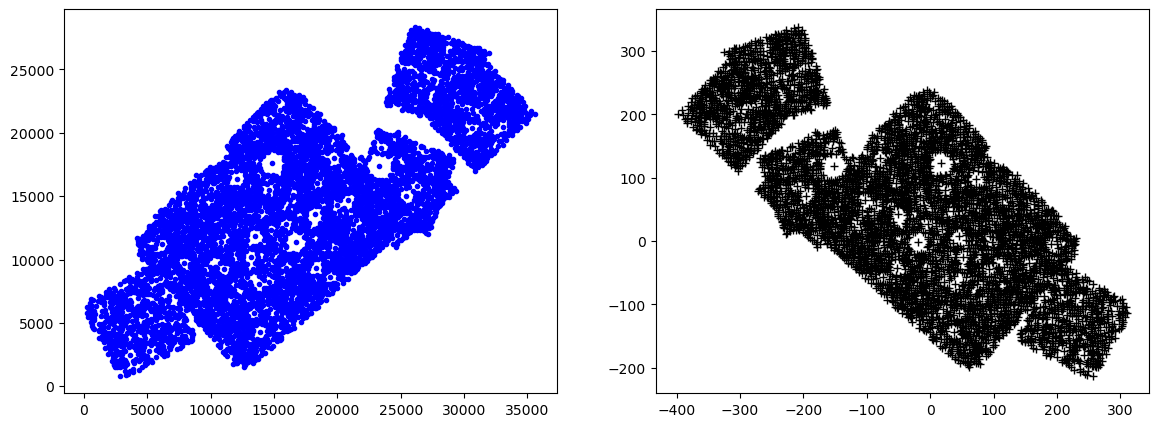

In [6]:
pixPos, relRaDecPos, gamma1, gamma2, z = readWLCatalog("./abell2744clu-grizli-v5.4-f200w-clear_drc_sci_clean.shears.photoz")

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.plot(pixPos[:,0], pixPos[:,1], '.', color="blue")
plt.gca().set_aspect("equal")
plt.subplot(1,2,2)
plt.plot(relRaDecPos[:,0]/ANGLE_ARCSEC, relRaDecPos[:,1]/ANGLE_ARCSEC, '+', color="black")
plt.gca().set_aspect("equal")
plt.show()

In [7]:
# The following function does this compensation, it also looks at the mapping from pixel positions to
# the recentered RA/DEC coordinates to check if there's a rotation involved as well (turns out to be
# very minor in this case)
gamma1, gamma2, rotAngle = util.adjustShearMeasurements(pixPos, gamma1, gamma2, relRaDecPos, mirror=True, tol=1e-10)
print("Rotation angle is", rotAngle/np.pi*180, "degrees")

Rotation angle is 0.008638296459456057 degrees


In [8]:
# Do the same for the other data sets
pixPosB, relRaDecPosB, gamma1B, gamma2B, zB = readWLCatalog("./abell2744clu-grizli-v5.4-f150w-clear_drc_sci_clean.shears.photoz")
gamma1B, gamma2B, rotAngleB = util.adjustShearMeasurements(pixPosB, gamma1B, gamma2B, relRaDecPosB, mirror=True, tol=1e-10)
print("Rotation angle is", rotAngleB/np.pi*180, "degrees")

pixPosC, relRaDecPosC, gamma1C, gamma2C, zC = readWLCatalog("./abell2744clu-grizli-v5.4-f115w-clear_drc_sci_clean.shears.photoz")
gamma1C, gamma2C, rotAngleC = util.adjustShearMeasurements(pixPosC, gamma1C, gamma2C, relRaDecPosC, mirror=True, tol=1e-10)
print("Rotation angle is", rotAngleC/np.pi*180, "degrees")

Rotation angle is 0.008552051656395441 degrees
Rotation angle is 0.008279559711848985 degrees


In [9]:
# Return the average shear in a box bounded by left, right, bottom and top
def getGammaAvg(pos, gamma1, gamma2, left, right, bottom, top):
    fltr = (pos[:,0] >= left) & (pos[:,0] < right) & (pos[:,1] >= bottom) & (pos[:,1] < top)
    if np.sum(fltr) == 0: # If there are no measurements, just return zero
        return 0.0, 0.0
    return np.mean(gamma1[fltr]), np.mean(gamma2[fltr])

In [10]:
# Combine the three datasets
relRaDecPosLarge=np.concatenate((relRaDecPos, relRaDecPosB, relRaDecPosC), axis=0)
gamma1Large = np.concatenate((gamma1, gamma1B, gamma1C), axis=0)
gamma2Large = np.concatenate((gamma2, gamma2B, gamma2C), axis=0)

In [11]:
# Use the function above to calculate average gamma's in squares of size 12.8 arcsec
def calcGammaAvg(ellPos, e1, e2, squareSize = 12.8*ANGLE_ARCSEC, Nhalf = 30):

    avgG = np.zeros((2*Nhalf,2*Nhalf,4))
    for y in range(-Nhalf,Nhalf):
        ybot = y*squareSize
        ytop = ybot + squareSize
        yctr = 0.5*(ybot+ytop)

        for x in range(-Nhalf,Nhalf):
            xleft = x*squareSize
            xright = xleft + squareSize
            xctr = 0.5*(xleft+xright)

            ypos, xpos = y+Nhalf,x+Nhalf
            avgG[ypos, xpos, 0] = xctr
            avgG[ypos, xpos, 1] = yctr

            gAvg = getGammaAvg(ellPos, e1, e2, xleft, xright, ybot, ytop)
            avgG[ypos, xpos, 2] = gAvg[0]
            avgG[ypos, xpos, 3] = gAvg[1]
            
    return avgG

avgG = calcGammaAvg(relRaDecPosLarge, gamma1Large, gamma2Large)

In [12]:
# Smoothen with a gaussian kernel
def smoothen(avgG, sigma):
    
    smoothG = avgG.copy()
    
    for y in range(avgG.shape[0]):
        for x in range(avgG.shape[1]):
    
            ctrPos = avgG[y,x,:2]
            diff = avgG[:,:,:2] - ctrPos
            dist2 = np.sum(diff**2,axis=2)
            relDist2 = dist2/(2*sigma**2)
            
            weights = np.exp(-relDist2)
            weightSum = np.sum(weights)
            
            smoothG1 = np.sum(weights * avgG[:,:,2])/weightSum
            smoothG2 = np.sum(weights * avgG[:,:,3])/weightSum
    
            smoothG[y,x,2] = smoothG1
            smoothG[y,x,3] = smoothG2
    
    return smoothG

smoothG = smoothen(avgG, 17*ANGLE_ARCSEC)

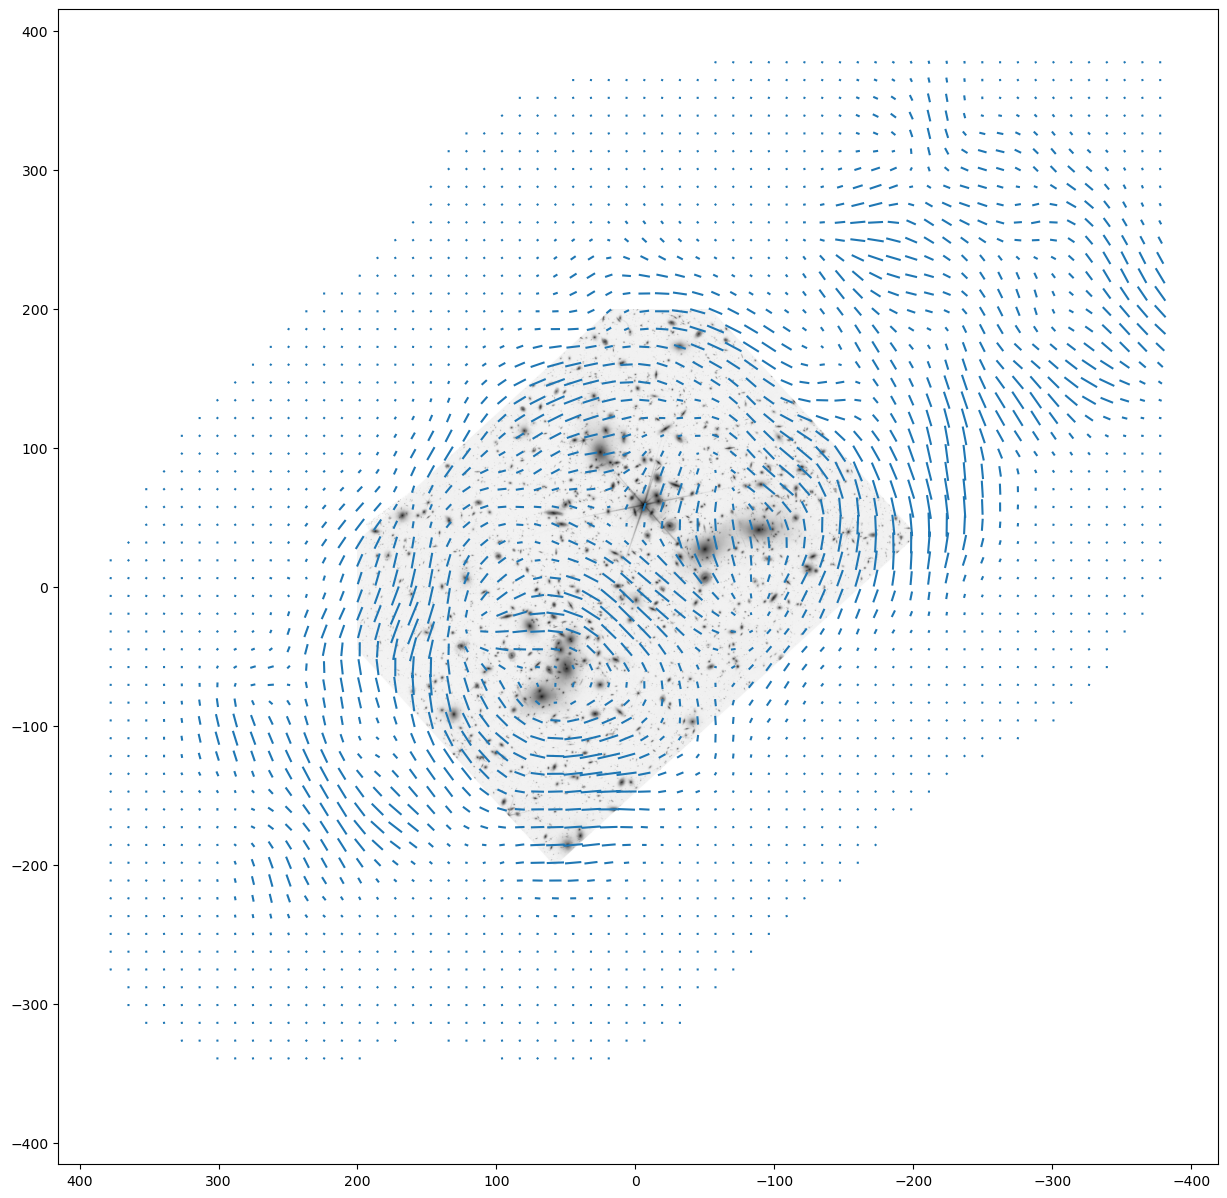

In [13]:
# And plot the resulting shear
plt.figure(figsize=(15,15))
plt.imshow(plt.imread("bg400x400_gray_inv.png"), extent=[200,-200,-200,200])

avgPos = smoothG[:,:,:2].reshape((-1,2))
avgG1 = smoothG[:,:,2].reshape((-1,))
avgG2 = smoothG[:,:,3].reshape((-1,))

plotShearComponents(avgPos/ANGLE_ARCSEC, [avgG1, avgG2], 100);

This is slide 17 of Masamune Oguri's lectures from "[Applications of gravitational lensing in astrophysics and cosmology](https://oguri.github.io/lectures/2012bnu.html)", the weak lensing part.

I'll use these equations to calculate E-mode and B-mode by approximating the integrals as summations.

<div>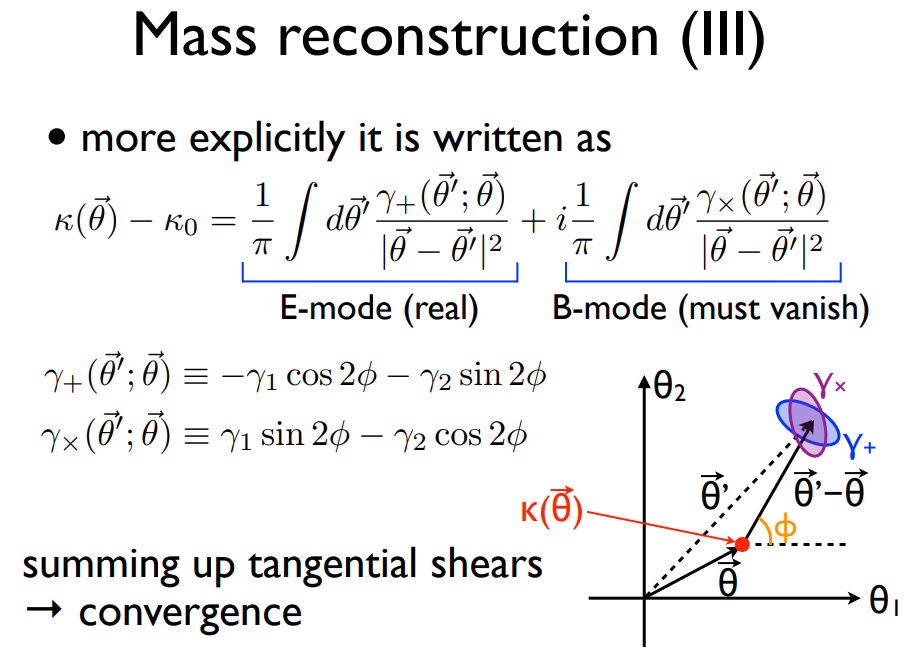</div>
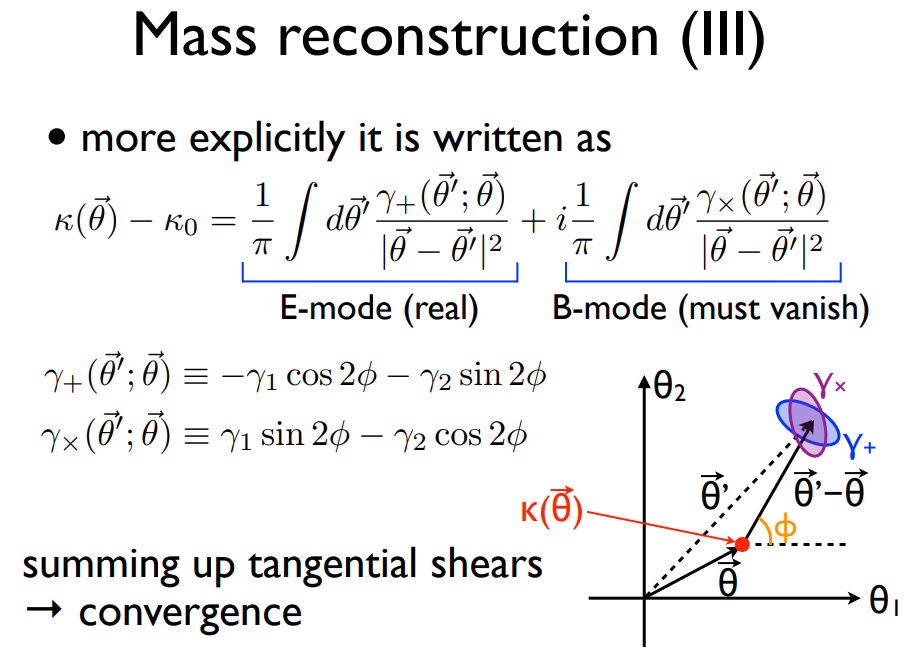

In [14]:
# Calculate E-mode and B-mode using the equations above. As you can see the
# the convergence kappa is basically the E-mode up to some constant. We'll
# already add some constant here to avoid kappa from becoming negative, but
# of course this is not the only possibility.
def calcEBMode(smoothG):
    EBmode = smoothG.copy()
    dx = EBmode[0,1,0] - EBmode[0,0,0]
    dy = EBmode[1,0,1] - EBmode[0,0,1]
    dxy = dx*dy
    for y in range(smoothG.shape[0]):
        for x in range(smoothG.shape[1]):
            theta = smoothG[y,x,:2]
    
            thetaDiff = smoothG[:,:,:2] - theta
            phi = np.arctan2(thetaDiff[:,:,1], thetaDiff[:,:,0])
            gamma1 = smoothG[:,:,2]
            gamma2 = smoothG[:,:,3]
            gammaPlus = -gamma1 * np.cos(2*phi) - gamma2 * np.sin(2*phi)
            gammaCross = gamma1 * np.sin(2*phi) - gamma2 * np.cos(2*phi)
            gammaPlus /= np.sum(thetaDiff**2, axis=2)
            gammaCross /= np.sum(thetaDiff**2, axis=2)

            gammaPlusSum = np.sum(gammaPlus[~np.isinf(gammaPlus)]) # Filter the division by zero
            gammaCrossSum = np.sum(gammaCross[~np.isinf(gammaCross)])
            
            EBmode[y,x,2] = gammaPlusSum*dxy
            EBmode[y,x,3] = gammaCrossSum*dxy

    EBmode[:,:,2] /= np.pi
    EBmode[:,:,3] /= np.pi
    
    # Add minimum of E-mode, to get something positive (represents mass density)
    EBmode[:,:,2] -= np.min(EBmode[:,:,2])
    return EBmode

EBmode = calcEBMode(smoothG)

/tmp/ipykernel_12063/4038026658.py:20: RuntimeWarning: divide by zero encountered in divide
  gammaPlus /= np.sum(thetaDiff**2, axis=2)
/tmp/ipykernel_12063/4038026658.py:21: RuntimeWarning: divide by zero encountered in divide
  gammaCross /= np.sum(thetaDiff**2, axis=2)


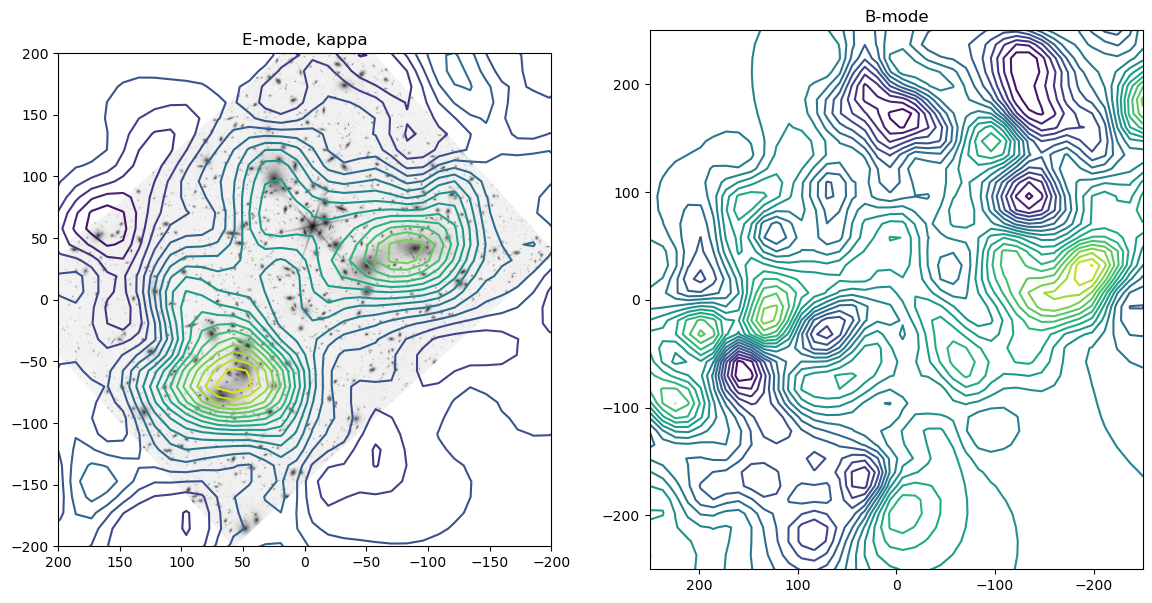

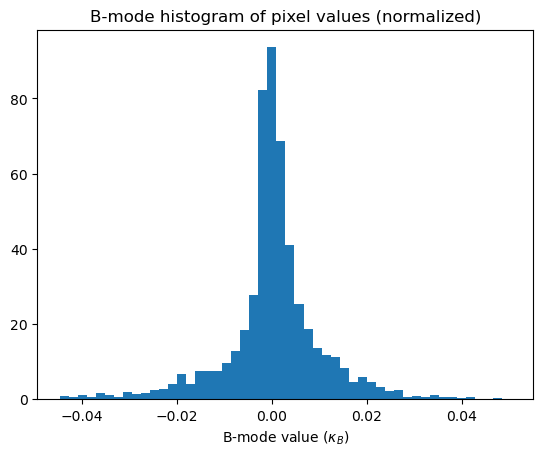

In [15]:
# And create some plots!
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(plt.imread("bg400x400_gray_inv.png"), extent=[200,-200,-200,200])
plt.contour(EBmode[:,:,0]/ANGLE_ARCSEC, EBmode[:,:,1]/ANGLE_ARCSEC, EBmode[:,:,2], levels=20)
plt.gca().set_xlim([200,-200])
plt.gca().set_ylim([-200,200])
plt.title("E-mode, kappa")

plt.subplot(1,2,2)
plt.contour(EBmode[:,:,0]/ANGLE_ARCSEC, EBmode[:,:,1]/ANGLE_ARCSEC, EBmode[:,:,3], levels=20)
plt.title("B-mode")
plt.gca().set_xlim([250,-250])
plt.gca().set_ylim([-250,250])

plt.figure()
plt.hist(EBmode[:,:,3].flatten(), density=True, bins=50);
plt.title("B-mode histogram of pixel values (normalized)")
plt.gca().set_xlabel("B-mode value ($\kappa_B$)");

In [16]:
# Let's add a 3D plot of kappa (E-mode) as well
plotutil.plot3DInteractive(EBmode[:,:,0]/ANGLE_ARCSEC, EBmode[:,:,1]/ANGLE_ARCSEC, EBmode[:,:,2], flipX=True, zlabel = "kappa")